**EN3150 Assignment 03: Simple convolutional neural network
to perform classification.**

**1 CNN for image classification**

In this assignment, you will create a simple image classifier using convolutional neural network (CNN). You have the freedom to use any programming language and toolkit of your choice, but it is recommended to use the Python programming language along with TensorFlow and Keras or PyTorch to construct the convolutional neural network (CNN).

1. Why CNNs preferable for image classification over multilayered perceptrons (MLPs)
or simple feedforward neural networks (NNs)?

2. Set up your environment: Ensure that you have installed all the required software
packages.

3. Prepare your dataset: Download the CIFAR-10 dataset. This dataset contains 60,000
color images in 10 different classes. Documentation of this data set can be found
in CIFAR-10 dataset. You may use listing 1 to load data. Further, apply suitable
feature scaling. Refer this for more information "pytorch normalization".

4. Split the dataset into training, validation, and testing subsets using a ratio of 60%
for training and 20% each for validation and testing sets1
.


In [1]:
# Include all the required libraries from pytorch
import torchvision # torchvision contains popular datasets, model architectures, and common image transformations.
import torchvision.transforms as transforms # transforms module allows image preprocessing like normalization, augmentation.
# (e.g., converting them to tensor format and normalizing the pixel values)
# Define data transformations (optional, but recommended)
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors (from PIL format or NumPy arrays).
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images by setting the mean and standard deviation for RGB channels.
])

# Load the training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', # Directory where the dataset will be downloaded (or located).
                                             train=True, # Specify that this is the training dataset.
                                             transform=transform, # Apply the transformation (ToTensor and normalization).
                                             download=True # Download the dataset if it's not already present.
                                             )

# Load the testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', # Directory where the dataset will be downloaded (or located).
                                            train=False, # Specify that this is the testing dataset.
                                            transform=transform, # Apply the same transformations as the training set.
                                            download=True  # Download the dataset if it's not already present.
                                            )

# Import necessary functions from the Keras library
from keras.datasets import cifar10 # Keras provides a CIFAR-10 dataset loader out-of-the-box.


# Load the CIFAR-10 dataset (which returns two tuples: one for training and one for testing).

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data() # Automatically splits data into train/test sets.


100%|██████████| 170498071/170498071 [00:04<00:00, 35335371.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
import torch  #is the main library for working with tensors and building neural networks in PyTorch.
from torch.utils.data import random_split #used to split a dataset into non-overlapping random subsets.


# Assuming you have already loaded the CIFAR-10 dataset into train_dataset and test_dataset

# Calculate the sizes for training, validation, and test sets
total_size = len(train_dataset) #Calculate the total number of samples in the training dataset.
train_size = int(0.6 * total_size) #Calculate 60% of the dataset for training.
val_size = int(0.2 * total_size) #Calculate 20% of the dataset for validation.
test_size = total_size - train_size - val_size #Calculate the remaining 20% for the test set.

# Split the dataset
train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size]) #Each subset is a random sampling of the original dataset, ensuring a balanced distribution of data between sets.

# Create data loaders for training, validation, and testing
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2) #Converts the subsets (train_set, val_set, and test_set) into PyTorch
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2) #objects, which allow for easy batch processing during model training and evaluation.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2) #batch_size=64: Defines the size of each batch of data (i.e., the number of images processed in parallel). Here, 64 samples are used per batch.



5. Build the CNN model: A common CNN design consists of interleaving convolutional
and max-pooling layers, ending with a linear classification layer [1]. This pattern is
illustrated in Figure 1
2
, and it was inspired by Fukushima’s neocognitron [2] and
Hubel and Wiesel’s work on human visual cortex [3]. Yann LeCun’s LeNet model
refined this approach in 1998, popularizing it through backpropagation and SGD [4].
In this example (Figure 1), we exclude normalization layers from the CNN design
because the model is relatively simple and not very deep. Here, the benefits of
normalization layers may not be visible. However, in deep neural networks, normalization layers, such as batch normalization or layer normalization, are often used to
improve training stability. They help mitigate issues like vanishing gradients and
can make it easier for deep networks to converge during training. Refer tensorflow
batch normalization and pytorch batch normalization for more information.


A basic CNN architecture is given below. Feel free to modify this network by adding
more layers.

• A Convolutional layer with x1 filters, a m1 × m1 kernel, and ’relu’ activation.

• A MaxPooling layer.

• Another Convolutional layer with x2 filters, a m2 × m2 kernel, and ’relu’ activation.

• Another MaxPooling layer.

• Flatten the output.

• A fully connected layer with x3 units and ’relu’ activation.

• Add dropout with a rate of d to reduce overfitting.

• An output layer with 10 units (for 10 classes) and ’softmax’ activation.

In [12]:
import torch #torch: Main PyTorch library for tensor operations.
import torch.nn as nn #Provides neural network layers, activations, and loss functions.
import torch.optim as optim #Contains optimization algorithms like SGD, Adam, etc.

class SimpleCNN(nn.Module):  #Defines a custom class SimpleCNN, which inherits from torch.nn.Module, the base class for all neural network modules in PyTorch.
    def __init__(self, x1, m1, x2, m2, x3, d):# Initializes the SimpleCNN model with hyperparameters: x1: Number of filters in the first convolutional layer. m1: Kernel size for the first convolutional layer. x2: Number of filters in the second convolutional layer. m2: Kernel size for the second convolutional layer. x3: Number of units in the fully connected (FC) layer. d: Dropout rate.
        super(SimpleCNN, self).__init__() #Calls the parent class (nn.Module) constructor to properly initialize the neural network.
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=x1, kernel_size=m1, stride=1, padding=1)
        self.relu1 = nn.ReLU() #ReLU activation function for introducing non-linearity.
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) #Max-pooling layer with a 2x2 kernel and a stride of 2, reducing the spatial dimensions by half.

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(in_channels=x1, out_channels=x2, kernel_size=m2, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer
        self.flatten = nn.Flatten() # Flattens the feature map into a 1D vector, preparing it for the fully connected layer.
        self.fc1 = nn.Linear(x2 * (32 // 4) * (32 // 4), x3)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=d) #Dropout layer with a dropout rate of d, to reduce overfitting by randomly setting some activations to zero during training.

        # Output layer
        self.fc2 = nn.Linear(x3, 10)  #Fully connected output layer with x3 input units and 10 output units, corresponding to the 10 classes in the CIFAR-10 dataset.
        self.softmax = nn.Softmax(dim=1) #Applies the softmax function across the class dimension to generate class probabilities.


    def forward(self, x): #Forward Pass:

        x = self.maxpool1(self.relu1(self.conv1(x))) #First convolutional layer, ReLU, and max-pooling.
        x = self.maxpool2(self.relu2(self.conv2(x))) #Second convolutional layer, ReLU, and max-pooling.
        x = self.flatten(x) #Flattening the output to a 1D vector.
        x = self.dropout(self.relu3(self.fc1(x))) #Fully connected layer, ReLU, and dropout.
        x = self.softmax(self.fc2(x)) #Output layer with softmax to return class probabilities.
        return x

# Instantiate the model
x1, m1, x2, m2, x3, d = 16, 3, 32, 3, 128, 0.5  # You can adjust these hyperparameters
#Creates an instance of SimpleCNN with specified hyperparameters: x1=16 filters in the first convolutional layer, kernel size m1=3, x2=32 filters in the second layer, x3=128 units in the fully connected layer, and d=0.5 dropout rate.
model = SimpleCNN(x1, m1, x2, m2, x3, d)

# Print the model architecture
print(model)

# Print model parameters in a table format
print("\nModel Parameters:")
for name, param in model.named_parameters():
    print(f"{name}\t\t{param.shape}\t\tTotal Parameters: {param.numel()}")

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Model Parameters:
conv1.weight		torch.Size([16, 3, 3, 3])		Total Parameters: 432
conv1.bias		torch.Size([16])		Total Parameters: 16
conv2.weight		torch.Size([32, 16, 3, 3])		Total Parameters: 4608
conv2.bias		torch.Size([32])		Total Parameters: 32
fc1.weight		torch.Size([128, 2048])		Total Parameters: 262144
fc1.bias		torch.Size([128])		Total Parameters: 128

6. Determine the parameters of the above network such as kernel sizes, filter sizes, size
of the fully connected layer and dropout rate.

In [4]:
x1, m1, x2, m2, x3, d = 16, 3, 32, 3, 128, 0.5  # Adjust these hyperparameters
model = SimpleCNN(x1, m1, x2, m2, x3, d)


7. Train the model: Train the model using the training data for 20 epochs and plot
training and validation loss for with respect to epoch. Here, for the optimizer
you may use adam and sparse categorical crossentropy as the loss function. Set
a suitable learning rate. Refer this page to see available optimizers keras optimizers and pytorch optimizers. More information about optimizer can be found in
https://cs231n.github.io/neural-networks



Epoch [1/20], Train Loss: 2.1501, Validation Loss: 2.0520
Epoch [2/20], Train Loss: 2.0416, Validation Loss: 1.9955
Epoch [3/20], Train Loss: 2.0034, Validation Loss: 1.9495
Epoch [4/20], Train Loss: 1.9780, Validation Loss: 1.9364
Epoch [5/20], Train Loss: 1.9571, Validation Loss: 1.9287
Epoch [6/20], Train Loss: 1.9407, Validation Loss: 1.9132
Epoch [7/20], Train Loss: 1.9274, Validation Loss: 1.8931
Epoch [8/20], Train Loss: 1.9144, Validation Loss: 1.8805
Epoch [9/20], Train Loss: 1.9031, Validation Loss: 1.8803
Epoch [10/20], Train Loss: 1.8901, Validation Loss: 1.8674
Epoch [11/20], Train Loss: 1.8821, Validation Loss: 1.8580
Epoch [12/20], Train Loss: 1.8731, Validation Loss: 1.8511
Epoch [13/20], Train Loss: 1.8669, Validation Loss: 1.8522
Epoch [14/20], Train Loss: 1.8599, Validation Loss: 1.8598
Epoch [15/20], Train Loss: 1.8512, Validation Loss: 1.8410
Epoch [16/20], Train Loss: 1.8440, Validation Loss: 1.8546
Epoch [17/20], Train Loss: 1.8385, Validation Loss: 1.8416
Epoch 

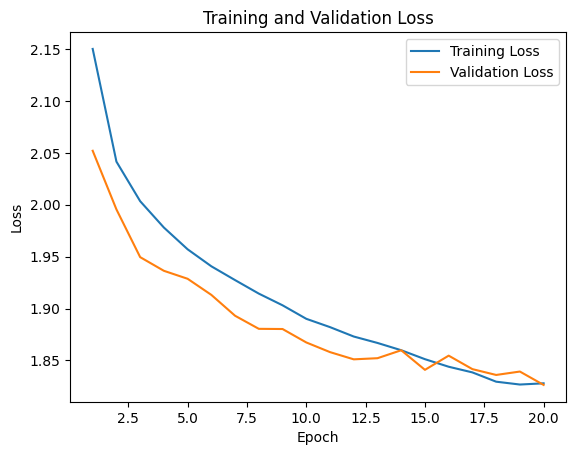

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming you have the train_loader and val_loader already defined

# Instantiate the model
x1, m1, x2, m2, x3, d = 16, 3, 32, 3, 128, 0.5
model = SimpleCNN(x1, m1, x2, m2, x3, d)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  #Loss Function: CrossEntropyLoss() is used because this is a classification task (CIFAR-10 has 10 classes).
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer: The Adam optimizer is used with a learning rate of 0.001. Adam is chosen for its adaptive learning rate, which often works well for deep learning tasks.

# Training loop
#The model will be trained for 20 epochs, and the losses during training and validation are stored in lists for visualization later.
num_epochs = 20
train_losses = []
val_losses = []

#Training Phase:
for epoch in range(num_epochs):
    model.train() #Model Training: The model is set to train() mode, where layers like dropout are activated
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad() #Zeroing Gradients: optimizer.zero_grad() ensures gradients are reset before the backward pass.
        outputs = model(inputs)
        loss = criterion(outputs, labels) #Loss Calculation: The difference between predicted outputs and actual labels is calculated using the loss function.
        loss.backward() #Loss Calculation: The difference between predicted outputs and actual labels is calculated using the loss function.
        optimizer.step() #The optimizer updates the model's parameters to minimize the loss using optimizer.step().
        running_loss += loss.item()#Average Loss Calculation: After each epoch, the average training loss is computed and stored.

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#Model Evaluation: The model is set to eval() mode, where certain layers (like dropout) behave differently, and no gradients are computed during forward passes.
    # Validation loss
    model.eval()
    val_loss = 0.0

    with torch.no_grad(): #No Gradient Calculation: torch.no_grad() is used to disable gradient computation, which reduces memory usage and speeds up the validation phase.
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)#Loss Calculation: Similar to the training loop, the loss is computed for validation data and averaged across batches.
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print progress
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot training and validation loss/ Loss Visualization
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#The primary goal of the training phase is to adjust the model's parameters (weights and biases) to minimize the loss function.
#The validation phase is used to evaluate the model's performance on a separate subset of the data that it hasn’t been trained on. This helps determine how well the model generalizes to new, unseen data.


8. Why we have chosen adam optimizer over SGD?



**Adaptive Learning Rates:**

Adam adjusts learning rates individually for each parameter based on historical gradients.

**Momentum and RMSprop Combined:**

Adam combines momentum and RMSprop techniques, leading to faster convergence and better generalization.

**Effective for Noisy Data and Sparse Gradients:**

Adam handles noisy data and sparse gradients well, making it suitable for real-world, complex datasets.

**No Need for Manual Learning Rate Tuning:**

Adam reduces the need for manual tuning of learning rates, providing robust performance across a range of hyperparameter choices.

**Efficient Memory Usage:**

Adam's use of moving averages for squared gradients results in efficient memory usage, beneficial for large datasets or limited computational resources.

**Well-suited for Deep Learning:**

Adam has demonstrated effectiveness in training deep neural networks, which often have complex architectures and numerous parameters.

9. Why we have chosen sparse categorical crossentropy as the loss function?



- **Single-Label Classification:**
  - Suitable for problems where each instance belongs to only one class.

- **Integer Class Labels:**
  - Designed for scenarios with integer class labels, avoiding the need for one-hot encoding.

- **Efficiency:**
  - Computationally efficient for a large number of classes, reducing the need for explicit one-hot encoding.

- **Memory Efficiency:**
  - Efficient memory usage, particularly important for deep learning models with limited resources.

- **Commonly Used for Classification:**
  - Standard choice for classification tasks, often used with softmax activation in the output layer.

- **Gradient Computation:**
  - Computationally efficient gradient computation, making it suitable for backpropagation in neural network training.

- **Handles Class Imbalance:**
  - Effective in dealing with class imbalance without requiring equal representation of each class.


10. Evaluate the Model: After training, evaluate the model’s performance on the testing
dataset. Record the train/test accuracy, confusion matrix, precision and recall.


Test Accuracy: 62.79%


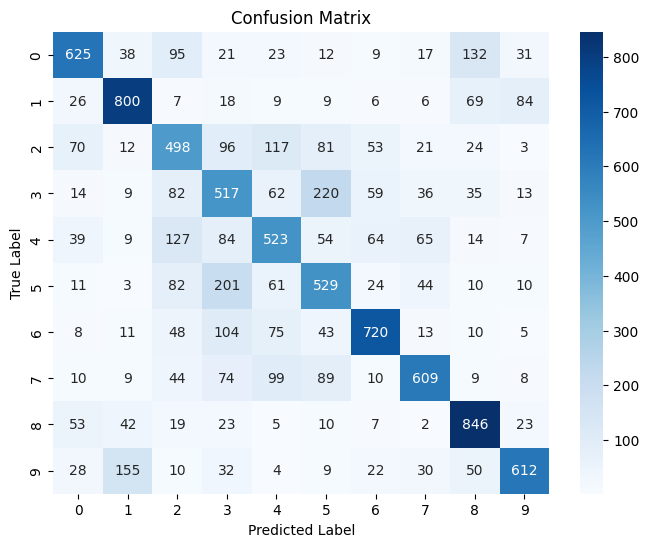

Weighted Precision: 0.6347
Weighted Recall: 0.6279


In [6]:
#Evaluate the Model:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the test_loader and the model already defined

# Set the model to evaluation mode
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)  # Get the index of the class with the maximum probability
        all_predictions.extend(predictions.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)  #This gives the percentage of correct predictions out of the total number of examples.
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
#Confusion Matrix: A confusion matrix is generated using confusion_matrix, which shows the count of predictions for each true class vs. the predicted class. It helps identify where the model is making classification errors:

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Precision and Recall
precision = precision_score(all_labels, all_predictions, average='weighted') #Precision measures the proportion of correct positive predictions out of all positive predictions (how many selected items are relevant).
recall = recall_score(all_labels, all_predictions, average='weighted') #Recall (or sensitivity) measures the proportion of actual positives that are correctly identified (how many relevant items are selected).

print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')


11. Plot training and validation loss for with respect to epoch for different learning rates
such as 0.0001, 0.001, 0.01, and 0.1.

**2 Compare your network with state-of-the-art networks***

"In practice, training an entire convolutional network from scratch (starting with
random initialization) is a rare occurrence. This is primarily due to the scarcity of
datasets of sufficient size. Instead, a common approach is to first pretrain a CNN
on an extensive dataset, such as ImageNet, which comprises 1.2 million images
across 1000 categories. Subsequently, this pretrained CNN can be utilized as either
an initialization point or a fixed feature extractor when tackling a specific task of
interest. This is known as transfer learning" 3
.

12. Choose two state-of-the-art pre-trained model or architecture like ImageNet, ResNet,
Googlenet, AlexNet, DenseNet and VGG.

13. Load the pre-trained model and fine-tune it for the CIFAR-10 dataset.

14. Train the fine-tuned model using the same training and testing data splits as your
custom CNN model.





15. Record training and validation loss values for each epoch.


In [ ]:
import torch
import torchvision
from torchvision import transforms, models #models: Contains pre-trained models (ResNet, DenseNet, etc.) that can be easily fine-tuned or used as feature extractors.
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score


# Function to load a pre-trained model and modify the classifier for CIFAR-10
#def load_and_modify_model(model_name): This function takes a model name (resnet or densenet) as input and returns a pre-trained model that's modified for the CIFAR-10 dataset (which has 10 classes).

def load_and_modify_model(model_name):
    if model_name == 'resnet':
        model = models.resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, 10)  # model.fc = nn.Linear(in_features, 10): Replaces the fully connected layer to output 10 classes instead of the original 1000 from ImageNet.
    elif model_name == 'densenet':
        model = models.densenet121(pretrained=True)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, 10)  # model.fc = nn.Linear(in_features, 10): Replaces the fully connected layer to output 10 classes instead of the original 1000 from ImageNet.
    else:
        raise ValueError("Invalid model name")

    return model

# Function to fine-tune the model
#def fine_tune_model: This function fine-tunes the provided model on the CIFAR-10 dataset.
def fine_tune_model(model, train_loader, test_loader, num_epochs=5, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #Checks if a GPU is available; if so, it assigns cuda to the device, otherwise cpu.
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    # Fine-tuning loop
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = running_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

# Choose the models to fine-tune
model_names = ['resnet', 'densenet']

# Fine-tune each model
#resnet
print(f"\nFine-tuning {model_names[0]} for CIFAR-10:")
pre_trained_resnet_model = load_and_modify_model(model_names[0])
train_resnet_losses, val_resnet_losses = fine_tune_model(pre_trained_resnet_model, train_loader, test_loader)

# Print the final training and validation loss values
print(f"\nFinal resnet Training  Loss: {train_resnet_losses[-1]:.4f}")
print(f"Final resnet Validation Loss: {val_resnet_losses[-1]:.4f}")

#densenet
print(f"\nFine-tuning {model_names[1]} for CIFAR-10:")
pre_trained_densenet_model = load_and_modify_model(model_names[1])
train_densenet_losses, val_densenet_losses = fine_tune_model(pre_trained_densenet_model, train_loader, test_loader)

# Print the final training and validation loss values
print(f"\nFinal densenet Training Loss: {train_densenet_losses[-1]:.4f}")
print(f"Final densenet Validation Loss: {val_densenet_losses[-1]:.4f}")


Fine-tuning resnet for CIFAR-10:


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


Epoch 1/5, Train Loss: 1.0641, Validation Loss: 0.8705
Epoch 2/5, Train Loss: 0.7246, Validation Loss: 0.9767
Epoch 3/5, Train Loss: 0.5831, Validation Loss: 0.6352
Epoch 4/5, Train Loss: 0.4554, Validation Loss: 0.6445
Epoch 5/5, Train Loss: 0.3569, Validation Loss: 0.6923

Final resnet Training  Loss: 0.3569
Final resnet Validation Loss: 0.6923

Fine-tuning densenet for CIFAR-10:


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 118MB/s]


Epoch 1/5, Train Loss: 0.9456, Validation Loss: 0.7117
Epoch 2/5, Train Loss: 0.6236, Validation Loss: 0.5735
Epoch 3/5, Train Loss: 0.5018, Validation Loss: 0.6390
Epoch 4/5, Train Loss: 0.3991, Validation Loss: 0.5520


16. Evaluate the fine-tuned model on the testing dataset and calculate the test accuracy

In [13]:
import torch
from sklearn.metrics import accuracy_score

# Function to evaluate a model on the testing dataset
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)  # Get the index of the class with the maximum probability
            all_predictions.extend(predictions.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Evaluate the fine-tuned models on the testing dataset
resnet_accuracy = evaluate_model(pre_trained_resnet_model, test_loader)
densenet_accuracy = evaluate_model(pre_trained_densenet_model, test_loader)

print(f"Test Accuracy (ResNet): {resnet_accuracy * 100:.2f}%")
print(f"Test Accuracy (Densenet): {densenet_accuracy * 100:.2f}%")


Test Accuracy (ResNet): 77.39%
Test Accuracy (Densenet): 81.73%


17. Compare the test accuracy of your custom CNN model with that of the fine-tuned
state-of-the-art model.



In [14]:

# Assuming you have the 'model' variable containing your custom CNN model

# Evaluate the custom CNN model on the testing dataset
print("\nEvaluation on Custom CNN:")
evaluate_model(model, test_loader)

# Compare with fine-tuned models
print("\nComparison of Test Accuracy:")
print(f"Custom CNN Test Accuracy: {accuracy * 100:.2f}%")
print(f"Fine-Tuned ResNet Test Accuracy: {resnet_accuracy * 100:.2f}%")
print(f"Fine-Tuned DenseNet Test Accuracy: {densenet_accuracy * 100:.2f}%")



Evaluation on Custom CNN:

Comparison of Test Accuracy:
Custom CNN Test Accuracy: 62.79%
Fine-Tuned ResNet Test Accuracy: 77.39%
Fine-Tuned DenseNet Test Accuracy: 81.73%


18. Discuss trade-offs, advantages, and limitations of using a custom model versus a
pre-trained model.